# **Bangkit Final Project: World Coin Classification**

# **Dependencies**

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import zipfile

from tensorflow.keras import backend
from tensorflow.keras.models import Sequential, Model, model_from_json, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LeakyReLU, Input
from tensorflow.keras.layers import GlobalAveragePooling2D, Lambda, Reshape, Activation, Concatenate
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import Regularizer, l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.metrics import categorical_accuracy

from google.colab import files, drive

In [ ]:
# Upload the kaggle.json file from Kaggle account settings page
uploaded = files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
# Install the Kaggle API client
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup
!chmod 600 ~/.kaggle/kaggle.json

# **Importing Dataset**

In [ ]:
# Download the dataset
!kaggle datasets download -d wanderdust/coin-images

 96% 442M/459M [00:02<00:00, 211MB/s]
100% 459M/459M [00:02<00:00, 172MB/s]


In [ ]:
# If kaggle is down, mount from drive
try:
    coin_file = open('/content/coin-images.zip', 'r')
    filepath = '/content/coin-images.zip'
except FileNotFoundError:
    # Keep preset values
    drive.mount('/content/drive')
    filepath = '/content/drive/My Drive/Bangkit project/Dataset/coin-images.zip'

# Unzip the dataset into folder
zip_ref = zipfile.ZipFile(filepath, 'r')
zip_ref.extractall('/content/')
zip_ref.close()

# **Data Preparation**

In [ ]:
# Define directories
data_dir = "/content/coins/data/"

train_dir = data_dir + "train/"
validation_dir = data_dir + "validation/"
test_dir = data_dir + "test/"

In [ ]:
# Create generators
train_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[0.8,1.2],
      horizontal_flip=False,
      vertical_flip=False,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False,
      fill_mode='nearest'
)

validation_datagen = ImageDataGenerator(
      rescale=1./255,
      rotation_range=360,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      brightness_range=[0.8,1.2],
      horizontal_flip=False,
      vertical_flip=False,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False,
      fill_mode='nearest'
)

test_datagen = ImageDataGenerator(
      rescale=1./255,
      featurewise_std_normalization=False,
      featurewise_center=False,
      samplewise_std_normalization=False,
      samplewise_center=False
)

In [ ]:
# Read images from generators
batch_size = 32
image_width = 224
image_height = 224
num_classes = 211

student_train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size,
      seed=42
)

student_validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=batch_size,
      seed=42
)

student_test_generator = test_datagen.flow_from_directory(
      test_dir,
      target_size=(image_width, image_height),
      class_mode="categorical",
      batch_size=1
)

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


In [ ]:
# Read images from generators
teacher_image_width = 299
teacher_image_height = 299

teacher_train_generator = train_datagen.flow_from_directory(
      train_dir,
      target_size=(teacher_image_width, teacher_image_height),
      class_mode="categorical",
      batch_size=batch_size,
      seed=42
)

teacher_validation_generator = validation_datagen.flow_from_directory(
      validation_dir,
      target_size=(teacher_image_width, teacher_image_height),
      class_mode="categorical",
      batch_size=batch_size,
      seed=42
)

Found 6413 images belonging to 211 classes.
Found 844 images belonging to 211 classes.


In [ ]:
def generate_generator(gen_x1, gen_x2):
    while True:
        x1 = gen_x1.__next__()
        x2 = gen_x2.__next__()
        dummy_y = np.zeros((x1[0].shape[0], image_width, image_height))
        yield [x1[0], x2[0], x1[1]], [dummy_y, x1[1]]

train_generator = generate_generator(student_train_generator, teacher_train_generator)
validation_generator = generate_generator(student_validation_generator, teacher_validation_generator)

# **Model**

In [ ]:
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
# Load teacher model
teacher_model_path = "/content/drive/My Drive/Bangkit project/models/ensemble_model.h5"
teacher_model = load_model(teacher_model_path, compile=False)

for layer in teacher_model.layers:
    layer.trainable = False

temperature = 5

# Create model to get logits from teacher model
teacher_model.layers.pop()
teacher_logits = teacher_model.layers[-1].output
teacher_logits_T = Lambda(lambda x: x / temperature)(teacher_logits)
teacher_probabilities_T = Activation('softmax', name='teacher_probabilities_T')(teacher_logits_T)

In [ ]:
# Load base model
base_model = MobileNetV2(input_shape=(image_width, image_height, 3), weights='imagenet', include_top=False)

for layer in base_model.layers:
    layer.trainable = True

    # Add regularizer
    l2_layer = l2(0.01)
    if hasattr(layer, 'kernel'):
        base_model.add_loss(lambda layer=layer: l2_layer(layer.kernel))

for layer in base_model.layers[:10]:
		layer.trainable = False

# Custom top classifier for model
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.55)(x)

# Usual probabilities
logits = Dense(num_classes, activation=None)(x)
probabilities = Activation('softmax', name='probabilities')(logits)

# Softed probabilities
logits_T = Lambda(lambda x: x / temperature)(logits)
probabilities_T = Activation('softmax', name='probabilities_T')(logits_T)

# Student model
student_model = Model(inputs=base_model.inputs, outputs=probabilities)
student_model.summary()

9412608/9406464 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
_______________________________

In [ ]:
def knowledge_distillation_loss(input_distillation, lambda_factor=0.9):
    y_pred, y_true, y_soft, y_pred_soft = input_distillation
    # Loss is not scaled with temperature^2 because it leads to worse results
    return ((1 - lambda_factor) * categorical_crossentropy(y_true, y_pred) +
            lambda_factor * categorical_crossentropy(y_soft, y_pred_soft))

# Train model
input_true = Input(shape=(211), name='input_true')
output_loss = Lambda(knowledge_distillation_loss, output_shape=(1,), name='output_loss')(
    [probabilities, input_true, teacher_probabilities_T, probabilities_T]
)
inputs = [base_model.input, teacher_model.input, input_true]
outputs = [output_loss, probabilities]
train_model = Model(inputs=inputs, outputs=outputs)

train_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

In [ ]:
losses = {
	"output_loss": lambda y_true, y_pred: y_pred,
	"probabilities": None
}
loss_weights = {"output_loss": 1.0, "probabilities": 0.0}

In [ ]:
# Callback to reduce learning rate if no improvement in validation loss for certain number of epochs
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, min_lr=1e-8, verbose=1)

# Callback to stop training if no improvement in validation loss for certain number of epochs
early_stop = EarlyStopping(monitor='val_loss', patience=20)

# Callback to save best model weights per epoch
weights_filepath = "best_model_weights.hdf5"
checkpoint = ModelCheckpoint(
    filepath=weights_filepath,
    monitor='val_probabilities_accuracy',
    mode='max',
    save_best_only=True,
    verbose=1
)

train_model.compile(loss=losses,
              loss_weights=loss_weights,
              optimizer=Nadam(lr=0.0001),
              metrics={'probabilities': 'accuracy'})

history = train_model.fit(
    train_generator,
    epochs=120,
    steps_per_epoch=50,
    validation_data=validation_generator,
    verbose=1,
    validation_steps=3,
    callbacks=[reduce_lr, checkpoint]
)

Epoch 1/120
50/50 [==============================] - ETA: 0s - loss: 5.3790 - output_loss_loss: 5.3790 - probabilities_accuracy: 0.0056
Epoch 00001: val_probabilities_accuracy improved from -inf to 0.01042, saving model to best_model_weights.hdf5
50/50 [==============================] - 88s 2s/step - loss: 5.3790 - output_loss_loss: 5.3790 - probabilities_accuracy: 0.0056 - val_loss: 5.3765 - val_output_loss_loss: 5.3765 - val_probabilities_accuracy: 0.0104 - lr: 1.0000e-04
Epoch 2/120
50/50 [==============================] - ETA: 0s - loss: 5.3535 - output_loss_loss: 5.3535 - probabilities_accuracy: 0.0113
Epoch 00002: val_probabilities_accuracy improved from 0.01042 to 0.04167, saving model to best_model_weights.hdf5
50/50 [==============================] - 85s 2s/step - loss: 5.3535 - output_loss_loss: 5.3535 - probabilities_accuracy: 0.0113 - val_loss: 5.3676 - val_output_loss_loss: 5.3676 - val_probabilities_accuracy: 0.0417 - lr: 1.0000e-04
Epoch 3/120
50/50 [====================

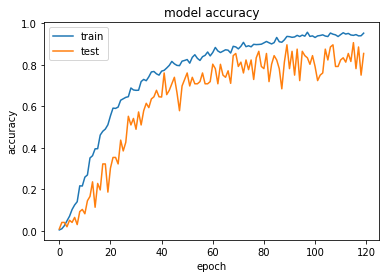

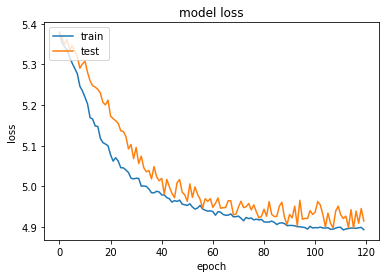

In [ ]:
# Visualise accuracy history
plt.plot(history.history['probabilities_accuracy'])
plt.plot(history.history['val_probabilities_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Visualise loss history
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
# Save model
model = student_model
model.compile(loss='categorical_crossentropy', optimizer=Nadam(lr=0.0001), metrics=['accuracy'])
model.save("improved_mobilenet_model.h5")

In [ ]:
# Evaluate model
train_score = model.evaluate_generator(student_train_generator, verbose=1)
print("Training loss: ", train_score[0])
print("Training accuracy: ", train_score[1])

validation_score = model.evaluate_generator(student_validation_generator, verbose=1)
print("Validation loss: ", validation_score[0])
print("Validation accuracy: ", validation_score[1])

test_score = model.evaluate(student_test_generator, verbose=1)
print("Testing loss: ", test_score[0])
print("Testing accuracy: ", test_score[1])

Instructions for updating:
Please use Model.evaluate, which supports generators.
201/201 [==============================] - 110s 548ms/step - loss: 0.1585 - accuracy: 0.9746
Training loss:  0.15845470130443573
Training accuracy:  0.974582850933075
27/27 [==============================] - 14s 520ms/step - loss: 0.7990 - accuracy: 0.8223
Validation loss:  0.7989630103111267
Validation accuracy:  0.8222748637199402
844/844 [==============================] - 9s 10ms/step - loss: 0.6609 - accuracy: 0.8566
Testing loss:  0.6609293818473816
Testing accuracy:  0.8566350936889648


In [ ]:
# Predict test images
predictions = []

for filename in student_test_generator.filenames:
    img = load_img(test_dir+filename, target_size=(image_width, image_height))
    img = img_to_array(img)/255
    img_expand = np.expand_dims(img, axis=0)
    predictions.append(model.predict(img_expand)[0])

In [ ]:
# Get index of largest probability
predicted_indices = np.argmax(predictions, axis=1)

# Get coin directory name from index 
directories = dict((v, k) for k, v in student_train_generator.class_indices.items())
predicted_dir = [directories.get(k) for k in predicted_indices]

# Get label name from coin directory name
with open(data_dir + 'cat_to_name.json', 'r') as json_file:
    labels = json.load(json_file)
predicted_labels = [labels.get(str(k)) for k in predicted_dir]

In [ ]:
# Save predicted labels as CSV file
filenames = student_test_generator.filenames
results = pd.DataFrame({"Filename": filenames, "Predictions": predicted_labels})
results.to_csv("improved_mobilenet_results.csv", index=False)
results.head()

,Filename,Predictions
0,1/021__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
1,1/022__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
2,1/027__1 Cent_australia.jpg,"2 Cents,Australian dollar,australia"
3,1/036__1 Cent_australia.jpg,"1 Cent,Australian dollar,australia"
4,10/005__5 Centavos_brazil.jpg,"5 Centavos,Brazilian Real,brazil"


# **Convert to TFLite**

In [ ]:
# Create converter
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS,
                                       tf.lite.OpsSet.SELECT_TF_OPS]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# Convert the model
tflite_model = converter.convert()
open("improved_mobilenet_model.tflite", "wb").write(tflite_model)

3054968

# **Copy model to Drive**

In [ ]:
drive.mount('/content/drive')
!cp improved_mobilenet_model.h5 "/content/drive/My Drive/Bangkit project/models"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
